# Laboratorio 8: DQN en CartPole

Integrantes:
- Javier Alejandro Azurdia Arrecis (21242)
- Diego Alejandro Morales Escobar (21146)
- Angel Sebastian Castellanos Pineda (21700)

In [4]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import math

## 1. Elegir un ambiente de Gymnasium:
- Selecciona un ambiente de Gymnasium que sea compatible con DQN. A continuación, algunos ejemplos recomendados:
  - `CartPole-v1`
  - `Taxi-v3`
  - `MountainCar-v0`
  - `Acrobot-v1` o `LunarLander-v2`


In [5]:
# Seleccionamos CartPole-v1 (recomendado para DQN)
env = gym.make('CartPole-v1', render_mode='human')


# Información del ambiente seleccionado
print(f"Ambiente seleccionado: CartPole-v1")
print(f"Espacio de observaciones: {env.observation_space}")
print(f"Espacio de acciones: {env.action_space}")

# Obtener dimensiones
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

print(f"Dimensiones del estado: {n_observations}")
print(f"Número de acciones posibles: {n_actions}")
print(f"Ejemplo de estado inicial: {state}")

env.close()

Ambiente seleccionado: CartPole-v1
Espacio de observaciones: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Espacio de acciones: Discrete(2)


<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Dimensiones del estado: 4
Número de acciones posibles: 2
Ejemplo de estado inicial: [ 0.03804139  0.0359551  -0.00650441  0.04100894]


## 2. Implementar el algoritmo DQN:
- Implementa el algoritmo **Deep Q-Network (DQN)** para resolver el ambiente que seleccionaste.
- Asegúrate de utilizar las técnicas clave de DQN, tales como:
  - **Experience Replay**: Almacena transiciones de experiencia en un buffer y reutilízalas para mejorar la eficiencia del entrenamiento.
  - **Target Network**: Utiliza una red de destino (*target network*) para estabilizar el entrenamiento al separar las actualizaciones del valor Q.

In [6]:
# 2.1 Experience Replay Buffer
print("2.1 Implementando Experience Replay...")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ExperienceReplayBuffer:
    """Buffer para almacenar y reutilizar experiencias pasadas"""
    
    def __init__(self, capacity):
        self.buffer = deque([], maxlen=capacity)
    
    def store_transition(self, *args):
        """Almacena una transición de experiencia"""
        self.buffer.append(Transition(*args))
    
    def sample_batch(self, batch_size):
        """Muestrea un batch aleatorio de experiencias"""
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

print("✓ Experience Replay Buffer implementado")

2.1 Implementando Experience Replay...
✓ Experience Replay Buffer implementado


In [7]:
# 2.2 Target Network
print("2.2 Implementando Target Network...")

class DQNTargetNetwork:
    """Maneja las actualizaciones de la red objetivo"""
    
    def __init__(self, policy_net, target_net):
        self.policy_net = policy_net
        self.target_net = target_net
        # Inicializar target network con los pesos de policy network
        self.update_target_network()
    
    def update_target_network(self):
        """Copia completamente los pesos de policy a target network"""
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def soft_update(self, tau=0.005):
        """Actualización suave de target network"""
        target_dict = self.target_net.state_dict()
        policy_dict = self.policy_net.state_dict()
        
        for key in policy_dict:
            target_dict[key] = policy_dict[key] * tau + target_dict[key] * (1 - tau)
        
        self.target_net.load_state_dict(target_dict)

print("✓ Target Network implementado")

2.2 Implementando Target Network...
✓ Target Network implementado


## 3. Consideraciones técnicas:
- **Red Neuronal**: Define una red neuronal que actúe como aproximador de la función Q. 
  - La entrada de la red será el estado del ambiente y la salida debe ser el valor Q para cada acción.
  - **Consejo**: Para ambientes sencillos como `CartPole-v1`, una red con una o dos capas ocultas de 128 o 256 neuronas debería ser suficiente.
- **Exploración vs. Explotación**: Implementa una política *epsilon-greedy* para balancear entre exploración y explotación.
  - Inicializa ϵ en un valor alto (0.9 o 1.0) y reduce gradualmente durante el entrenamiento.

In [8]:
class DQNetwork(nn.Module):
    """Red neuronal para aproximar la función Q"""
    
    def __init__(self, input_size, output_size, hidden_size=128):
        super(DQNetwork, self).__init__()
        # Red con dos capas ocultas como se recomienda
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """Forward pass: estado → valores Q para cada acción"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

print("✓ Red neuronal definida con 2 capas ocultas de 128 neuronas")

✓ Red neuronal definida con 2 capas ocultas de 128 neuronas


In [9]:
class EpsilonGreedyPolicy:
    """Implementa exploración vs explotación con epsilon-greedy"""
    
    def __init__(self, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=1000):
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0
    
    def get_epsilon(self):
        """Calcula epsilon actual con decaimiento exponencial"""
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                 math.exp(-1. * self.steps_done / self.epsilon_decay)
        return epsilon
    
    def select_action(self, policy_net, state, n_actions):
        """Selecciona acción usando epsilon-greedy"""
        self.steps_done += 1
        epsilon = self.get_epsilon()
        
        if random.random() > epsilon:
            # Explotación: mejor acción según Q-network
            with torch.no_grad():
                return policy_net(state).max(1)[1].view(1, 1)
        else:
            # Exploración: acción aleatoria
            return torch.tensor([[random.randrange(n_actions)]], 
                              dtype=torch.long)

print("✓ Política Epsilon-Greedy implementada (ε inicial: 1.0 → 0.01)")

✓ Política Epsilon-Greedy implementada (ε inicial: 1.0 → 0.01)


## 4. Hiperparámetros importantes:
- **Tasa de aprendizaje**: Un valor típico está entre 0.001 y 0.0001.
- **Tasa de descuento (γ)**: Determina cuánto valoras las recompensas futuras. Un valor común es 0.99.
- **Batch Size**: Selecciona un tamaño de batch adecuado (por ejemplo, 32 o 64 muestras) al actualizar la red.
- **Tamaño del buffer de experiencia**: Un tamaño común es de 10,000 transiciones, aunque esto puede variar según el ambiente.

In [10]:
# Definir hiperparámetros según las recomendaciones
LEARNING_RATE = 0.0001       # Tasa de aprendizaje
DISCOUNT_FACTOR = 0.99      # Gamma - factor de descuento
BATCH_SIZE = 64            # Tamaño del batch
BUFFER_SIZE = 10000        # Tamaño del buffer de experiencia
TARGET_UPDATE_FREQ = 100   # Frecuencia de actualización de target network

In [11]:
print(f"Tasa de aprendizaje: {LEARNING_RATE}")
print(f"Factor de descuento (γ): {DISCOUNT_FACTOR}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Tamaño del buffer: {BUFFER_SIZE}")
print(f"Frecuencia actualización target: cada {TARGET_UPDATE_FREQ} episodios")

Tasa de aprendizaje: 0.0001
Factor de descuento (γ): 0.99
Batch size: 64
Tamaño del buffer: 10000
Frecuencia actualización target: cada 100 episodios


In [12]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cuda


## 5. Entrenamiento y evaluación:
- **Entrena el modelo**: Corre el entrenamiento por al menos 500-1,000 episodios o hasta que la tarea sea resuelta (según la definición del ambiente).
- **Visualiza el progreso**: Muestra el promedio de recompensas por episodio para observar si el agente está aprendiendo.

In [13]:
class DQNAgent:
    """Agente DQN completo que integra todos los componentes"""
    
    def __init__(self, state_size, action_size):
        # Inicializar redes
        self.policy_net = DQNetwork(state_size, action_size).to(device)
        self.target_net = DQNetwork(state_size, action_size).to(device)
        
        # Inicializar componentes
        self.target_manager = DQNTargetNetwork(self.policy_net, self.target_net)
        self.replay_buffer = ExperienceReplayBuffer(BUFFER_SIZE)
        self.epsilon_policy = EpsilonGreedyPolicy(
            epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=10000
        )
        
        # Optimizador
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        
        # Variables de seguimiento
        self.action_size = action_size
        self.episode_rewards = []
        self.episode_lengths = []
    
    def select_action(self, state):
        """Selecciona acción usando política epsilon-greedy"""
        return self.epsilon_policy.select_action(
            self.policy_net, state, self.action_size
        )
    
    def store_experience(self, state, action, next_state, reward):
        """Almacena experiencia en el buffer"""
        self.replay_buffer.store_transition(state, action, next_state, reward)
    
    def optimize_model(self):
        """Realiza un paso de optimización del modelo"""
        if len(self.replay_buffer) < BATCH_SIZE:
            return
        
        # Muestrear batch de experiencias
        transitions = self.replay_buffer.sample_batch(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        
        # Procesar batch
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)
        
        non_final_next_states = torch.cat([s.to(device) for s in batch.next_state if s is not None])
        state_batch = torch.cat([s.to(device) for s in batch.state])
        action_batch = torch.cat([a.to(device) for a in batch.action])
        reward_batch = torch.cat([r.to(device) for r in batch.reward])
        
        # Calcular valores Q actuales
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Calcular valores Q del siguiente estado usando target network
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        
        # Calcular valores Q objetivo
        expected_state_action_values = (next_state_values * DISCOUNT_FACTOR) + reward_batch
        
        # Calcular pérdida
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # Optimizar
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping para estabilidad
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

In [14]:
def train_dqn_agent(episodes=1000):
    """Función principal de entrenamiento"""
    print(f"Iniciando entrenamiento por {episodes} episodios...")
    
    # Crear ambiente y agente
    env = gym.make('CartPole-v1', render_mode='human')
    agent = DQNAgent(n_observations, n_actions)
    
    # Listas para tracking
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(episodes):
        # Reiniciar episodio
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        total_reward = 0
        steps = 0
        
        # Ejecutar episodio
        for t in range(500):  # Máximo 500 pasos
            # Seleccionar y ejecutar acción
            action = agent.select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            
            total_reward += reward
            steps += 1
            
            # Convertir a tensores
            reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)
            done = terminated or truncated
            
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, 
                                        device=device).unsqueeze(0)
            
            # Almacenar experiencia
            agent.store_experience(state, action, next_state, reward_tensor)
            
            # Mover al siguiente estado
            state = next_state
            
            # Optimizar modelo
            agent.optimize_model()
            
            if done:
                break
        
        # Actualizar target network periódicamente
        if episode % TARGET_UPDATE_FREQ == 0:
            agent.target_manager.update_target_network()
        
        # Guardar métricas
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        # Mostrar progreso cada 100 episodios
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_length = np.mean(episode_lengths[-100:])
            epsilon = agent.epsilon_policy.get_epsilon()
            
            print(f"Episodio {episode + 1}/{episodes}")
            print(f"  Reward promedio (últimos 100): {avg_reward:.2f}")
            print(f"  Longitud promedio (últimos 100): {avg_length:.2f}")
            print(f"  Epsilon actual: {epsilon:.3f}")
            
            # Verificar si la tarea está resuelta
            if avg_reward >= 200.0:  # Criterio de CartPole-v1
                print(f"¡Tarea resuelta en episodio {episode + 1}!")
                break
    
    env.close()
    return agent, episode_rewards, episode_lengths

In [15]:
def visualize_training_progress(episode_rewards, episode_lengths):
    """Visualiza el progreso del entrenamiento"""
    print("Generando visualizaciones del progreso...")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Gráfico de recompensas
    episodes = range(len(episode_rewards))
    ax1.plot(episodes, episode_rewards, alpha=0.6, label='Reward por episodio')
    
    # Media móvil
    window_size = 100
    if len(episode_rewards) >= window_size:
        moving_avg = np.convolve(episode_rewards, 
                               np.ones(window_size)/window_size, mode='valid')
        ax1.plot(range(window_size-1, len(episode_rewards)), moving_avg, 
                'r-', linewidth=2, label=f'Media móvil ({window_size})')
    
    ax1.axhline(y=200, color='g', linestyle='--', label='Objetivo (200)')
    ax1.set_title('Progreso del Entrenamiento: Recompensas')
    ax1.set_xlabel('Episodio')
    ax1.set_ylabel('Recompensa Total')
    ax1.legend()
    ax1.grid(True)
    
    # Gráfico de duración de episodios
    ax2.plot(episodes, episode_lengths, alpha=0.6, label='Duración por episodio')
    
    if len(episode_lengths) >= window_size:
        moving_avg_length = np.convolve(episode_lengths, 
                                      np.ones(window_size)/window_size, mode='valid')
        ax2.plot(range(window_size-1, len(episode_lengths)), moving_avg_length, 
                'r-', linewidth=2, label=f'Media móvil ({window_size})')
    
    ax2.set_title('Progreso del Entrenamiento: Duración de Episodios')
    ax2.set_xlabel('Episodio')
    ax2.set_ylabel('Pasos Sobrevividos')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas finales
    print(f"Reward promedio final (últimos 100 episodios): {np.mean(episode_rewards[-100:]):.2f}")
    print(f"Duración promedio final (últimos 100 episodios): {np.mean(episode_lengths[-100:]):.2f}")

Iniciando fase de entrenamiento...
Iniciando entrenamiento por 1000 episodios...
Episodio 100/1000
  Reward promedio (últimos 100): 21.19
  Longitud promedio (últimos 100): 21.19
  Epsilon actual: 0.811
Episodio 200/1000
  Reward promedio (últimos 100): 19.64
  Longitud promedio (últimos 100): 19.64
  Epsilon actual: 0.668
Episodio 300/1000
  Reward promedio (últimos 100): 31.04
  Longitud promedio (últimos 100): 31.04
  Epsilon actual: 0.493
Episodio 400/1000
  Reward promedio (últimos 100): 97.36
  Longitud promedio (últimos 100): 97.36
  Epsilon actual: 0.192
Episodio 500/1000
  Reward promedio (últimos 100): 156.07
  Longitud promedio (últimos 100): 156.07
  Epsilon actual: 0.048
Episodio 600/1000
  Reward promedio (últimos 100): 177.16
  Longitud promedio (últimos 100): 177.16
  Epsilon actual: 0.017
Episodio 700/1000
  Reward promedio (últimos 100): 350.81
  Longitud promedio (últimos 100): 350.81
  Epsilon actual: 0.010
¡Tarea resuelta en episodio 700!

Visualizando progreso del

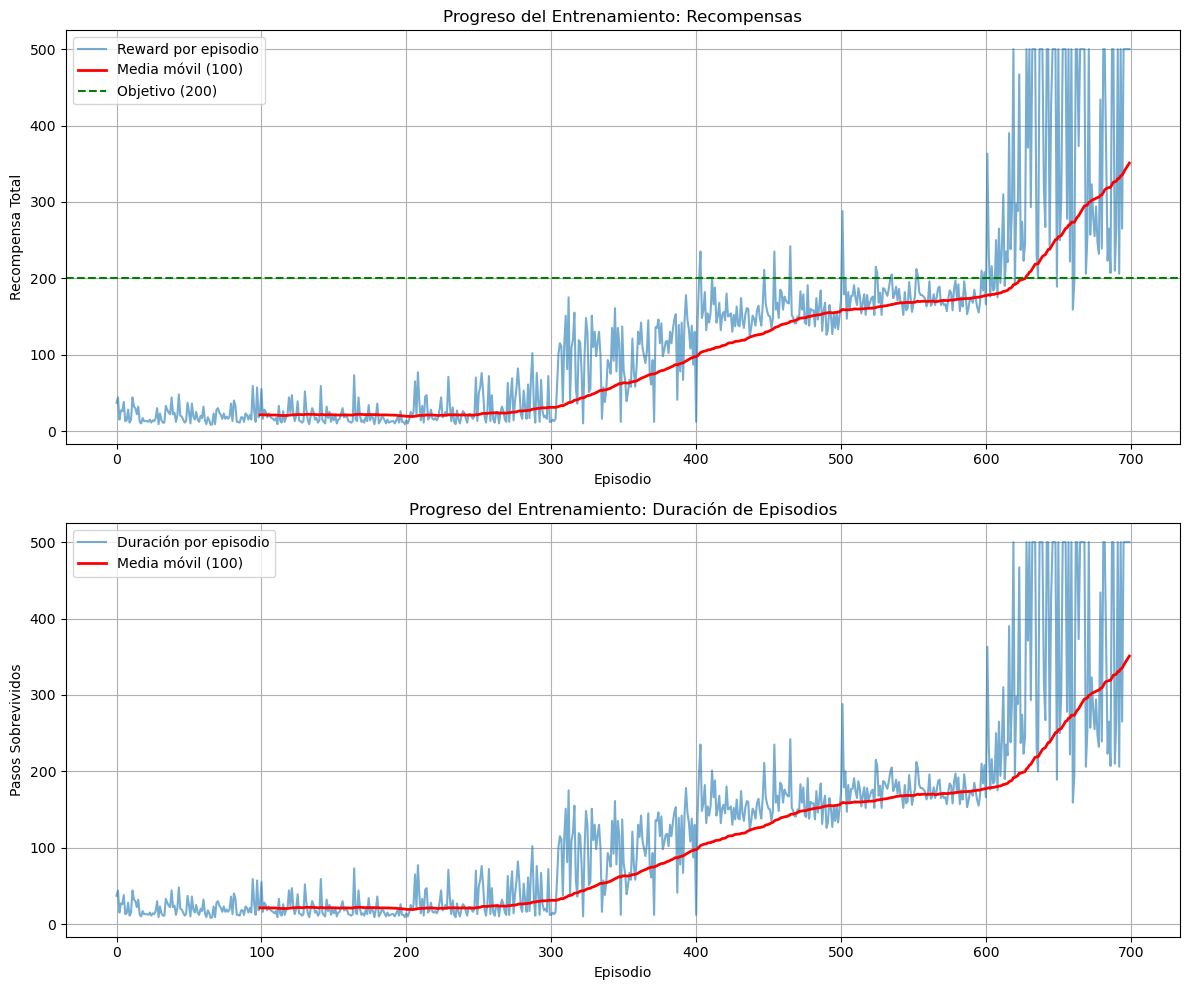

Reward promedio final (últimos 100 episodios): 350.81
Duración promedio final (últimos 100 episodios): 350.81




In [16]:
# Ejecutar entrenamiento
print("Iniciando fase de entrenamiento...")
trained_agent, rewards, lengths = train_dqn_agent(episodes=1000)

print("\nVisualizando progreso del entrenamiento...")
visualize_training_progress(rewards, lengths)
print("\n")

## 6. Evaluación final:
- Después de entrenar el DQN, evalúa el desempeño del agente ejecutando varios episodios sin explorar (usando solo la política aprendida) para ver cómo se comporta.
  - **Consejo**: Si implementaste todo correctamente, deberías observar que el agente mejora con el tiempo y logra completar la tarea de manera eficiente.
  - **Presentación**: Graba un video de cómo se comporta el agente y preséntalo en Canvas.

In [17]:
def evaluate_trained_agent(agent, num_episodes=10, render=False):
    """Evalúa el agente entrenado sin exploración"""
    print(f"Evaluando agente entrenado en {num_episodes} episodios...")
    
    # Crear ambiente para evaluación
    env = gym.make('CartPole-v1', render_mode='human' if render else None)
    test_rewards = []
    test_lengths = []
    
    # Desactivar exploración (epsilon = 0)
    original_steps = agent.epsilon_policy.steps_done
    agent.epsilon_policy.steps_done = float('inf')  # Forzar epsilon = epsilon_end
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        
        total_reward = 0
        steps = 0
        
        for t in range(500):
            # Usar solo explotación (sin exploración)
            with torch.no_grad():
                action = agent.policy_net(state).max(1)[1].view(1, 1)
            
            observation, reward, terminated, truncated, _ = env.step(action.item())
            total_reward += reward
            steps += 1
            
            if terminated or truncated:
                break
            
            state = torch.tensor(observation, dtype=torch.float32, 
                               device=device).unsqueeze(0)
        
        test_rewards.append(total_reward)
        test_lengths.append(steps)
        print(f"  Episodio {episode + 1}: {total_reward} pasos")
    
    # Restaurar configuración original
    agent.epsilon_policy.steps_done = original_steps
    env.close()
    
    # Resultados de evaluación
    avg_reward = np.mean(test_rewards)
    avg_length = np.mean(test_lengths)
    
    print(f"\nResultados de la evaluación:")
    print(f"  Recompensa promedio: {avg_reward:.2f}")
    print(f"  Duración promedio: {avg_length:.2f} pasos")
    
    return test_rewards, test_lengths

In [22]:
print("Realizando evaluación final del agente entrenado...")
eval_rewards, eval_lengths = evaluate_trained_agent(trained_agent, num_episodes=20, render=True)

Realizando evaluación final del agente entrenado...
Evaluando agente entrenado en 20 episodios...
  Episodio 1: 500.0 pasos
  Episodio 2: 500.0 pasos
  Episodio 3: 500.0 pasos
  Episodio 4: 500.0 pasos
  Episodio 5: 433.0 pasos
  Episodio 6: 500.0 pasos
  Episodio 7: 392.0 pasos
  Episodio 8: 500.0 pasos
  Episodio 9: 393.0 pasos
  Episodio 10: 500.0 pasos
  Episodio 11: 362.0 pasos
  Episodio 12: 500.0 pasos
  Episodio 13: 500.0 pasos
  Episodio 14: 500.0 pasos
  Episodio 15: 490.0 pasos
  Episodio 16: 500.0 pasos
  Episodio 17: 500.0 pasos
  Episodio 18: 500.0 pasos
  Episodio 19: 297.0 pasos
  Episodio 20: 500.0 pasos

Resultados de la evaluación:
  Recompensa promedio: 468.35
  Duración promedio: 468.35 pasos


In [23]:
# Guardar modelo entrenado
print(f"\nGuardando modelo entrenado...")
torch.save({
    'policy_net_state_dict': trained_agent.policy_net.state_dict(),
    'target_net_state_dict': trained_agent.target_net.state_dict(),
    'optimizer_state_dict': trained_agent.optimizer.state_dict(),
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'discount_factor': DISCOUNT_FACTOR,
        'batch_size': BATCH_SIZE,
        'buffer_size': BUFFER_SIZE
    }
}, 'dqn_cartpole_trained_model.pth')

print("✓ Modelo guardado como 'dqn_cartpole_trained_model.pth'")


Guardando modelo entrenado...
✓ Modelo guardado como 'dqn_cartpole_trained_model.pth'


In [24]:
print(f"Episodios de entrenamiento: {len(rewards)}")
print(f"Recompensa final promedio: {np.mean(eval_rewards):.2f}")


Episodios de entrenamiento: 700
Recompensa final promedio: 468.35
